# BERT Fine-Tuning on CoLA with UCI and SiFT



This notebook is orginally created by Chris McCormick and Nick Ryan. We made changes for SiFT and SMART, as well as our custom BERT class.

##Data and Importing Modules 

In [2]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [3]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [4]:
!pip install transformers

     |████████████████████████████████| 2.3MB 30.1MB/s 
     |████████████████████████████████| 901kB 38.4MB/s 
     |████████████████████████████████| 3.3MB 38.9MB/s 


In [5]:
!pip install wget

  Created wheel for wget: filename=wget-3.2-cp37-none-any.whl size=9681 sha256=ea154f89435dd44a5821388a8d9c569c7b235e5cbebbcdc043a81f0f82817ac9
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [6]:
#Adding the datasets to the collab file

#First we mount the google drive

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [7]:
# with open('/content/drive/My Drive/Undergraduate/Courses/MLLU Project/Code/Baseline - Draft Proposal/yelp_labelled.txt', 'r') as f:
#   f.write('Successfully opened Yelp Labelled')

with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/yelp_labelled.txt', 'r') as y:
  print("Successfully Opened Yelp")


with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/amazon_cells_labelled.txt', 'r') as a:
  print("Successfully Opened Amazon Labelled")



with open('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/imdb_labelled.txt', 'r') as i:
  print("Successfully Opened IMDB Labelled")

Successfully Opened Yelp
Successfully Opened Amazon Labelled
Successfully Opened IMDB Labelled


In [8]:
#Checking on the Yelp Dataframe
import pandas as pd
df1_yelp = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/yelp_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_yelp.head()

print(df1_yelp.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1000 non-null   object
 1   Label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


In [10]:

#Similarly for the dataframes for Amazon and IMDB
df1_amazon = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/amazon_cells_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_amazon.head()
print(df1_amazon.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  1000 non-null   object
 1   Label     1000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 15.8+ KB
None


In [11]:
df1_imdb = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/imdb_labelled.txt', delimiter = '\t', delim_whitespace= False, names = ('Sentence', 'Label'))
df1_imdb.head()
print(df1_imdb.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  748 non-null    object
 1   Label     748 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 11.8+ KB
None


In [12]:

combinedDF = pd.concat([df1_imdb, df1_amazon, df1_yelp], axis = 0, join = 'inner')
combinedDF.head()
combinedDF.info()
combinedDF.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2748 non-null   object
 1   Label     2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


,Sentence,Label
0,"A very, very, very slow-moving, aimless movie ...",0
1,Not sure who was more lost - the flat characte...,0
2,Attempting artiness with black & white and cle...,0
3,Very little music or anything to speak of.,0
4,The best scene in the movie was when Gerardo i...,1
5,"The rest of the movie lacks art, charm, meanin...",0
6,Wasted two hours.,0
7,Saw the movie today and thought it was a good ...,1
8,A bit predictable.,0
9,Loved the casting of Jimmy Buffet as the scien...,1


In [13]:
combinedDF = combinedDF.sample(frac = 1).reset_index(drop = True)
combinedDF = combinedDF.dropna()
combinedDF.info()
combinedDF.head(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2748 entries, 0 to 2747
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  2748 non-null   object
 1   Label     2748 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 64.4+ KB


,Sentence,Label
0,"Not much flavor to them, and very poorly const...",0
1,Damian is so talented and versatile in so many...,1
2,"Unfortunately, inexperience of direction meant...",0
3,We aren't ones to make a scene at restaurants ...,0
4,The Veggitarian platter is out of this world!,1
5,poor voice clarity.,0
6,Restored my phone to like new performance.,1
7,He was terrible!,0
8,I was looking for this headset for a long time...,1
9,"Not much dialogue, not much music, the whole f...",1


In [14]:
df1_twitter = pd.read_csv('/content/drive/MyDrive/Undergraduate /Courses /MLLU Project/Code/MLLU : Final Paper Submission Code/train.csv', names = ('Label', 'Sentence'))
df1_twitter = df1_twitter.iloc[1:4000]

df1_twitter['Label'] = df1_twitter['Label'].astype(int, errors = 'raise')

In [15]:
df1_twitter.head()
df1_twitter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3999 entries, 1 to 3999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Label     3999 non-null   int64 
 1   Sentence  3999 non-null   object
dtypes: int64(1), object(1)
memory usage: 93.7+ KB


In [16]:
df1_twitter.head(10)
sentences = df1_twitter.Sentence.values
labels = df1_twitter.Label.values

print(type(labels[0]))

<class 'numpy.int64'>


## Tokenization and DataLoader

In [17]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [19]:
print(' Original: ', sentences[0])
print('Tokenized: ', tokenizer.tokenize(sentences[0]))
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Tokenized:  ['@', 'user', 'when', 'a', 'father', 'is', 'dysfunction', '##al', 'and', 'is', 'so', 'selfish', 'he', 'drag', '##s', 'his', 'kids', 'into', 'his', 'dysfunction', '.', '#', 'run']
Token IDs:  [1030, 5310, 2043, 1037, 2269, 2003, 28466, 2389, 1998, 2003, 2061, 14337, 2002, 8011, 2015, 2010, 4268, 2046, 2010, 28466, 1012, 1001, 2448]


In [20]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))


print(len(sentences))
print('Max sentence length: ', max_len)

3999
Max sentence length:  76


In [22]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 32,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:   @user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction.   #run
Token IDs: tensor([  101,  1030,  5310,  2043,  1037,  2269,  2003, 28466,  2389,  1998,
         2003,  2061, 14337,  2002,  8011,  2015,  2010,  4268,  2046,  2010,
        28466,  1012,  1001,  2448,   102,     0,     0,     0,     0,     0,
            0,     0])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [23]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)
print(type(input_ids))
print(type(attention_masks))
print(type(labels))
# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
3,599 training samples
  400 validation samples


In [24]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. 
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )


print("hi")

hi


## Custom Bert Class and Initialization

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig, BertPreTrainedModel, BertModel
from transformers.models.bert.modeling_bert import BertEmbeddings,BertEncoder,BertPooler
from transformers.modeling_outputs import BaseModelOutputWithPoolingAndCrossAttentions

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss

class CustomBertForClassification(BertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        #self.bert = BertForSequenceClassification(config).from_pretrained("bert-base-uncased",num_labels = 2,output_attentions = False, output_hidden_states = False)
        self.embeddings = self.bert.embeddings
        self.encoder = self.bert.encoder
        self.pooler = self.bert.pooler

    def embed(self, input_ids=None, 
                    token_type_ids=None, 
                    position_ids=None, 
                    inputs_embeds=None, 
                    past_key_values_length=0):
        # See: BERTModel.forward
        return self.embeddings(
            input_ids=input_ids,
            position_ids=position_ids,
            token_type_ids=token_type_ids,
            inputs_embeds=inputs_embeds,
            past_key_values_length=past_key_values_length
        )
    
    def predict(self,embedding_output,
                extended_attention_mask=None,
                head_mask=None,
                encoder_hidden_states=None,
                encoder_extended_attention_mask=None,
                past_key_values=None,
                use_cache=None,
                output_attentions=None,
                output_hidden_states=None,
                return_dict=True):
      # See: BERTModel.forward 
        encoder_outputs = self.encoder(
            embedding_output,
            attention_mask=extended_attention_mask,
            head_mask=head_mask,
            encoder_hidden_states=encoder_hidden_states,
            encoder_attention_mask=encoder_extended_attention_mask,
            past_key_values=past_key_values,
            use_cache=use_cache,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        sequence_output = encoder_outputs[0]
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None
        
        bert_output = BaseModelOutputWithPoolingAndCrossAttentions(
                    last_hidden_state=sequence_output,
                    pooler_output=pooled_output,
                    past_key_values=encoder_outputs.past_key_values,
                    hidden_states=encoder_outputs.hidden_states,
                    attentions=encoder_outputs.attentions,
                    cross_attentions=encoder_outputs.cross_attentions,
                )

        pooled_output = bert_output[1]

        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)
        
        return logits


In [26]:
#@title
model = CustomBertForClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2,
    output_attentions = False, 
    output_hidden_states = False, 
)

model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing CustomBertForClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing CustomBertForClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CustomBertForClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CustomBertForClassification were not initialized from the model checkpoint at bert-ba

CustomBertForClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

##Noise Function

In [27]:
from torch.nn import LayerNorm
import torch.nn.functional as F

def normalize_embed(embed):
    embed_mean = torch.mean(embed,dim=(1,2))
    embed_std = torch.std(embed, dim=(1,2))

    embed_clone = torch.clone(embed)

    for i in range(0,embed_clone.size()[0]):
        # embed_clone[i] = torch.div(torch.sub(embed_clone[i],embed_mean[i]),embed_std[i])
        embed_clone[i] = (embed_clone[i] - embed_mean[i]) / embed_std[i]
    return embed_clone, embed_mean, embed_std

def denormalize_embed(embed, embed_mean, embed_std):
    for i in range(0,embed.size()[0]):
        # embed[i] = (embed[i] - embed_mean[i]) / embed_std[i]
        embed[i] = (embed[i] * embed_std[i]) + embed_mean[i]
    return embed 

def stable_kl(logit, target, epsilon=1e-6, reduce=True):
    logit = logit.view(-1, logit.size(-1)).float()
    target = target.view(-1, target.size(-1)).float()
    bs = logit.size(0)
    p = F.log_softmax(logit, 1).exp()
    y = F.log_softmax(target, 1).exp()
    rp = -(1.0/(p + epsilon) -1 + epsilon).detach().log()
    ry = -(1.0/(y + epsilon) -1 + epsilon).detach().log()
    if reduce:
        return (p* (rp- ry) * 2).sum() / bs
    else:
        return (p* (rp- ry) * 2).sum()

def _norm_grad(grad, epsilon = 1e-6, eff_grad=None, sentence_level=False):
        if sentence_level:
            direction = grad / (grad.abs().max((-2, -1), keepdim=True)[0] + epsilon)
        else:
            direction = grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
            eff_direction = eff_grad / (grad.abs().max(-1, keepdim=True)[0] + epsilon)
        return direction, eff_direction

def noise(embed, model,step_size, normalize=False, k=1, mean=0, std=0.01):  ## Not including mask in the noise, so it means no mask as input for predict, should be a problem
    if normalize == True:
        logits = model.predict(embed)#,attention_mask)
        # LNorm = LayerNorm(embed.size(),elementwise_affine=False)
        # normalized_embed = LNorm(embed)
        normalized_embed, embed_mean, embed_std = normalize_embed(embed)

        noise = torch.normal(mean=0, std=0.01,size=(normalized_embed.size()[0],normalized_embed.size()[1],normalized_embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_normalized_embeddings = normalized_embed+noise
        adv_logits = model.predict(noised_normalized_embeddings)#,attention_mask)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_normalized_embeddings = normalized_embed+noise
        denormalize_noised_embed = denormalize_embed(noised_normalized_embeddings,embed_mean, embed_std) 
        return denormalize_noised_embed
    else:
        logits = model.predict(embed)#,attention_mask)
        noise = torch.normal(mean=0, std=0.01,size=(embed.size()[0],embed.size()[1],embed.size()[2]))
        noise = noise.to(device)
        noise.requires_grad_()
        noised_embeddings = embed+noise
        adv_logits = model.predict(noised_embeddings)#,attention_mask)
        adv_loss = stable_kl(adv_logits, logits.detach(), reduce=False)
        delta_grad, = torch.autograd.grad(adv_loss, noise, only_inputs=True, retain_graph=False)
        norm = delta_grad.norm()
        # if (torch.isnan(norm) or torch.isinf(norm)):
        #     return 0
        eff_delta_grad = delta_grad * step_size
        delta_grad = noise + delta_grad * step_size
        noise, eff_noise = _norm_grad(delta_grad, eff_grad=eff_delta_grad, sentence_level=0)
        noise = noise.detach()
        noised_embeddings = embed+noise
        return noised_embeddings

## Optimizer, Scheduler, and Some Other Training Prep

In [28]:
#@title
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8 
                )

In [29]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [30]:
#@title
import numpy as np
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [31]:
#@title
import time
import datetime

def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [32]:
MODE = "SMART-adv-only"

##Training Loop with Validation

In [33]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        embed = model.embed(input_ids = b_input_ids)
        preds = model.predict(embedding_output = embed)#,extended_attention_mask=b_input_mask)   <- Didn't use mask at all, which should be a problem
        loss_fct = CrossEntropyLoss()
        regular_loss = loss_fct(preds.view(-1,2), b_labels.view(-1))
        loss_list = [regular_loss]
        if MODE in ["SMART-adv-only", "SIFT"]:
          normalise = True if MODE == "SIFT" else False
          noised_embeddings = noise(embed, model, 1e-3, normalize=normalise, k=1)
          adv_logits = model.predict(embedding_output = noised_embeddings)#,extended_attention_mask = b_input_mask)   <- Didn't use mask at all, which should be a problem

          adv_loss = stable_kl(preds.view(-1,2), adv_logits.view(-1,2))
          loss_list.append(adv_loss)
        loss = sum(loss_list)
        # END MODEL
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)   

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:20.
  Batch    80  of    113.    Elapsed: 0:00:40.

  Average training loss: 0.25
  Training epcoh took: 0:00:57

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:21.
  Batch    80  of    113.    Elapsed: 0:00:42.

  Average training loss: 0.14
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:21.
  Batch    80  of    113.    Elapsed: 0:00:42.

  Average training loss: 0.09
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.95
  Validation Loss: 0.14
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:21.
  Batch    80  of    113.    Elapsed: 0:

Let's view the summary of the training process.

In [34]:

import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,0.25,0.18,0.93,0:00:57,0:00:01
2,0.14,0.15,0.95,0:00:59,0:00:01
3,0.09,0.14,0.95,0:00:59,0:00:01
4,0.09,0.16,0.95,0:00:58,0:00:01


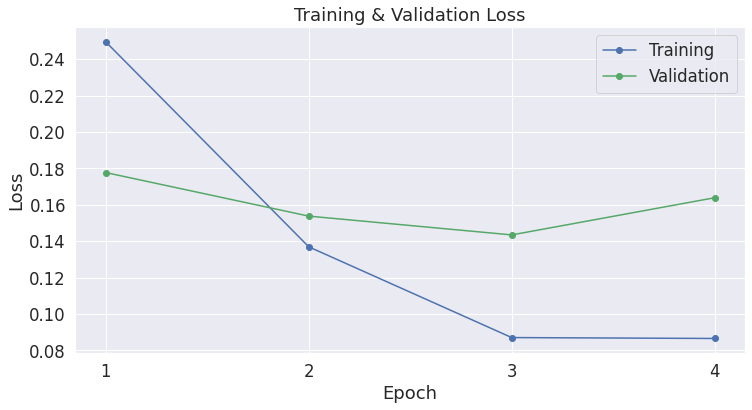

In [35]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [36]:
total_test_loss = []
total_test_accuracy = []



for batch in validation_dataloader:

        
  # Unpack this training batch from our dataloader. 
  #
  # As we unpack the batch, we'll also copy each tensor to the GPU using 
  # the `to` method.
  #
  # `batch` contains three pytorch tensors:
  #   [0]: input ids 
  #   [1]: attention masks
  #   [2]: labels 
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
        
  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  #with torch.no_grad():        

  # Forward pass, calculate logit predictions.
  # token_type_ids is the same as the "segment ids", which 
  # differentiates sentence 1 and 2 in 2-sentence tasks.
  result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
  loss = result.loss
  logits = result.logits
        
            
        # Accumulate the validation loss.
  total_test_loss = loss.item()

        # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
  total_test_accuracy = flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
print("The total test accuracy is: ")
print(total_test_accuracy)
print("Testing complete!")

The total test accuracy is: 
0.9375
Testing complete!


## Now we train again on the 10% of the dataset

In [ ]:
df1_split_10_percent_test = combinedDF.iloc[:874, :]
df1_split_10_percent_train = combinedDF.iloc[875:, :]

df1_split_10_percent_test.head(10)
df1_split_10_percent_test.info()

In [38]:
sentences2 = df1_split_10_percent_train.Sentence.values
labels2 = df1_split_10_percent_train.Label.values


print(len(sentences2))

1873


In [39]:
max_len3 = 0

# For every sentence...
for sent in sentences2:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids2 = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len3 = max(max_len3, len(input_ids2))

print('Max sentence length: ', max_len3)

Token indices sequence length is longer than the specified maximum sequence length for this model (1103 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  1103


In [40]:
input_ids2 = []
attention_masks2 = []

# For every sentence...
for sent in sentences2:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict2 = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids2.append(encoded_dict2['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks2.append(encoded_dict2['attention_mask'])

# Convert the lists into tensors.
input_ids2 = torch.cat(input_ids2, dim=0)
attention_masks2 = torch.cat(attention_masks2, dim=0)
labels2 = torch.tensor(labels2)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences2[0])
print('Token IDs:', input_ids2[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  I was able to do voice dialing in the car with no problem.
Token IDs: tensor([  101,  1045,  2001,  2583,  2000,  2079,  2376, 13764,  2075,  1999,
         1996,  2482,  2007,  2053,  3291,  1012,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [41]:
train2_dataset = TensorDataset(input_ids2, attention_masks2, labels2)

print(type(input_ids2))
print(type(attention_masks2))
print(type(labels2))



train2_dataloader = DataLoader(
            train2_dataset, # The validation samples.
            sampler = SequentialSampler(train2_dataset), # Pull out batches sequentially.
            batch_size = 16 # Evaluate with this batch size.
        )


print(len(train2_dataset))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
1873


In [80]:
optimizer2 = AdamW(model.parameters(),
                  lr = 2e-4,
                  eps = 1e-8 
                )

In [81]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()
    total_train_loss = 0
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train2_dataloader):
        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        model.zero_grad()        

        embed = model.embed(input_ids = b_input_ids)
        preds = model.predict(embedding_output = embed)#,extended_attention_mask=b_input_mask)   <- Didn't use mask at all, which should be a problem
        loss_fct = CrossEntropyLoss()
        regular_loss = loss_fct(preds.view(-1,2), b_labels.view(-1))
        loss_list = [regular_loss]
        if MODE in ["SMART-adv-only", "SIFT"]:
          normalise = True if MODE == "SIFT" else False
          noised_embeddings = noise(embed, model, 1e-3, normalize=normalise, k=1)
          adv_logits = model.predict(embedding_output = noised_embeddings)#,extended_attention_mask = b_input_mask)   <- Didn't use mask at all, which should be a problem

          adv_loss = stable_kl(preds.view(-1,2), adv_logits.view(-1,2))
          loss_list.append(adv_loss)
        loss = sum(loss_list)
        # END MODEL
        total_train_loss += loss.item()
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer2.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            

    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():        

            result = model(b_input_ids, 
                           token_type_ids=None, 
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)


        loss = result.loss
        logits = result.logits

        total_eval_loss += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        total_eval_accuracy += flat_accuracy(logits, label_ids)   

    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    validation_time = format_time(time.time() - t0)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:19.
  Batch    80  of    113.    Elapsed: 0:00:38.

  Average training loss: 0.77
  Training epcoh took: 0:00:57

Running Validation...
  Accuracy: 0.08
  Validation Loss: 0.80
  Validation took: 0:00:01

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:20.
  Batch    80  of    113.    Elapsed: 0:00:40.

  Average training loss: 0.76
  Training epcoh took: 0:00:59

Running Validation...
  Accuracy: 0.08
  Validation Loss: 0.76
  Validation took: 0:00:01

======== Epoch 3 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:21.
  Batch    80  of    113.    Elapsed: 0:00:42.

  Average training loss: 0.76
  Training epcoh took: 0:01:01

Running Validation...
  Accuracy: 0.92
  Validation Loss: 0.68
  Validation took: 0:00:01

======== Epoch 4 / 4 ========
Training...
  Batch    40  of    113.    Elapsed: 0:00:21.
  Batch    80  of    113.    Elapsed: 0:

# Final Test on the rest of the UCI Dataset

In [82]:

combinedDF['Label'] = combinedDF['Label'].astype(int, errors = 'raise')
sentences3 = df1_split_10_percent_test.Sentence.values
labels3 = df1_split_10_percent_test.Label.values

In [83]:
max_len3 = 0

# For every sentence...
for sent in sentences3:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids3 = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len3 = max(max_len3, len(input_ids3))

print('Max sentence length: ', max_len3)

Max sentence length:  1790


In [84]:
input_ids3 = []
attention_masks3 = []

# For every sentence...
for sent in sentences3:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict3 = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids3.append(encoded_dict3['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks3.append(encoded_dict3['attention_mask'])

# Convert the lists into tensors.
input_ids3 = torch.cat(input_ids3, dim=0)
attention_masks3 = torch.cat(attention_masks3, dim=0)
labels3 = torch.tensor(labels3)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences3[0])
print('Token IDs:', input_ids3[0])


print(len(sentences3))


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2110: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  Not much flavor to them, and very poorly constructed.
Token IDs: tensor([  101,  2025,  2172, 14894,  2000,  2068,  1010,  1998,  2200,  9996,
         3833,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])
874


In [85]:
test_dataset = TensorDataset(input_ids3, attention_masks3, labels3)

print(type(input_ids3))        
print(type(attention_masks3))
print(type(labels3))



test_dataloader = DataLoader(        
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = 32 
        )


print(len(test_dataset))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>
874


In [86]:
torch.cuda.memory_summary(device=None, abbreviated=False)


'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |    2628 MB |    5901 MB |   21604 GB |   21601 GB |\n|       from large pool |    2580 MB |    5789 MB |   21353 GB |   21351 GB |\n|       from small pool |      47 MB |     165 MB |     250 GB |     250 GB |\n|---------------------------------------------------------------------------|\n| Active memory         |    2628 MB |    5901 MB |   21604 GB |   21601 GB |\n|       from large pool |    2580 MB |    5789 MB |

In [87]:
total_test_loss2 = []
total_test_accuracy2 = []



for batch in test_dataloader:

        
  # Unpack this training batch from our dataloader. 
  #
  # As we unpack the batch, we'll also copy each tensor to the GPU using 
  # the `to` method.
  #
  # `batch` contains three pytorch tensors:
  #   [0]: input ids 
  #   [1]: attention masks
  #   [2]: labels 
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
        
  # Tell pytorch not to bother with constructing the compute graph during
  # the forward pass, since this is only needed for backprop (training).
  #with torch.no_grad():        

  # Forward pass, calculate logit predictions.
  # token_type_ids is the same as the "segment ids", which 
  # differentiates sentence 1 and 2 in 2-sentence tasks.
  result = model(b_input_ids, 
                       token_type_ids=None, 
                       attention_mask=b_input_mask, 
                       labels=b_labels,
                       return_dict=True)
        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
  loss = result.loss
  logits = result.logits
        
            
        # Accumulate the validation loss.
  total_test_loss = loss.item()

        # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
  total_test_accuracy = flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
print("The total test accuracy is: ")
print(total_test_accuracy)
print("Testing complete!")

The total test accuracy is: 
0.7
Testing complete!
